## Building a Fashion Generative Adversarial Neural Network with Tensorflow

### 1. Import Dependencies and Data

In [42]:
# !pip install tensorflow-datasets ipywidgets

In [43]:
# Bringing in tensorflow datasets for fashion mnist
import tensorflow as tf
import tensorflow_datasets as tfds
# Bringing in matplotlif for viz stuff
from matplotlib import pyplot as plt

In [44]:
# Use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

In [45]:
type(ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [46]:
ds.as_numpy_iterator().next()

2024-10-11 16:36:16.796879: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

In [47]:
ds.as_numpy_iterator().next().keys()

2024-10-11 16:36:16.857767: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


dict_keys(['image', 'label'])

### 2. Viz Data and Build Dataset

In [48]:
# Do some data transformation
import numpy as np

In [49]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

2024-10-11 16:36:16.919964: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [50]:
np.squeeze(dataiterator.next()['image']).shape

(28, 28)

In [51]:
# Getting data out of the pipeline
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 59],
         [ 77],
         [ 58],
         [ 56],
         [ 58],
         [ 57],
         [ 65],
         [ 89],
         [  2],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [245],
         [213],
         [199],
         [192],
         [188],
         [189],
         [184],
         [226],
         [ 90],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

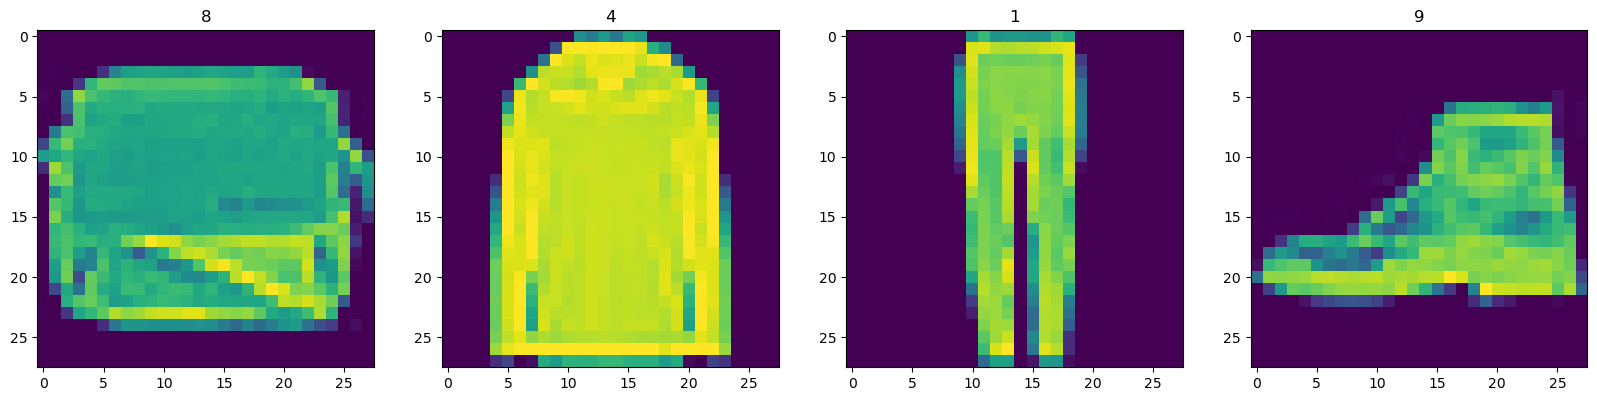

In [52]:
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx in range(4):
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title
    ax[idx].title.set_text(sample['label'])

In [53]:
ax

array([<Axes: title={'center': '8'}>, <Axes: title={'center': '4'}>,
       <Axes: title={'center': '1'}>, <Axes: title={'center': '9'}>],
      dtype=object)

In [54]:
# Scale and return images only
def scale_images(data):
    image = data['image']
    return image / 255

In [55]:
# Reloaded the dataset
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images)
# Cache the dataset for that batch
ds = ds.cache()
# Shuffle it up
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking
ds = ds.prefetch(64)

In [56]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

### 3. Build Neural Network

#### 3.1 Import Modelling Components

In [57]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network 
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

#### 3.2 Build Generator

In [58]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshapes it to 7x7x8
    # beginnings of a generated image 
    model.add(Dense(7*7*8, input_dim=8))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,8)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(8, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(8, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(8, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [59]:
generator = build_generator()

In [60]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 392)               3528      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 392)               0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 8)           0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 14, 14, 8)        0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 8)         1608      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 14, 14, 8)         0         
                                                      

1/1 [==============================] - 0s 120ms/step


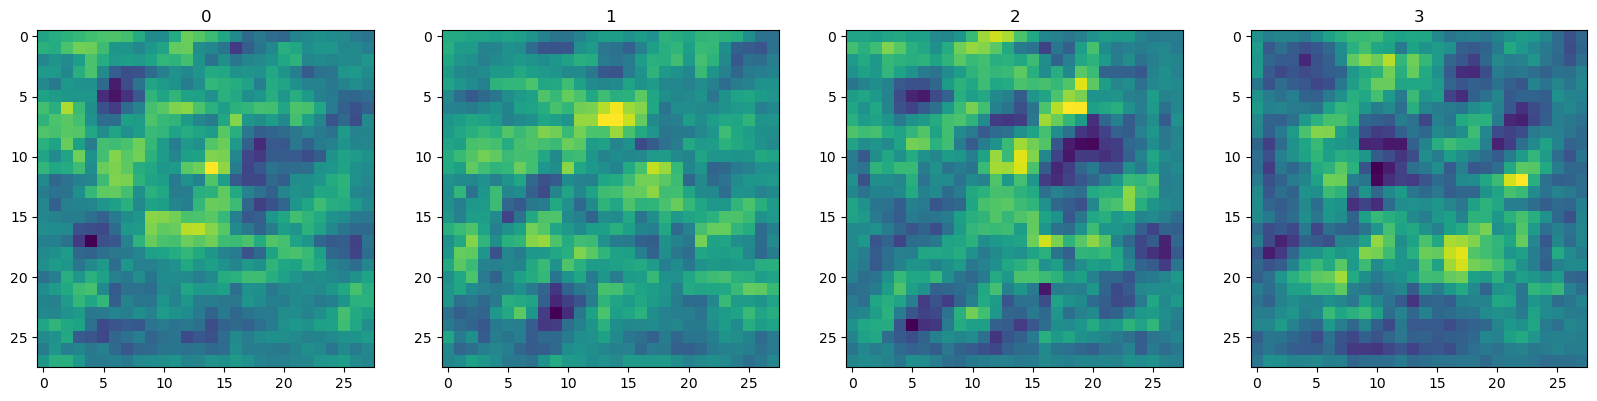

In [61]:
# Generate new fashion
img = generator.predict(np.random.randn(4, 8, 1))
# Setup the subplot formatting
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images
for idx, img in enumerate(img):
    # Plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title
    ax[idx].title.set_text(idx)

#### 3.3 Build Discriminator

In [62]:
def build_discriminator():
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(8, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(8, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass through dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [63]:
discriminator = build_discriminator()

In [64]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 24, 24, 8)         208       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 24, 24, 8)         0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 8)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 20, 20, 8)         1608      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 20, 20, 8)         0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 8)         0         
                                                                 
 flatten_2 (Flatten)         (None, 3200)             

In [65]:
np.expand_dims?

Signature:       np.expand_dims(a, axis)
Call signature:  np.expand_dims(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function expand_dims at 0x772a69b2c1f0>
File:            ~/miniconda3/envs/dl-env/lib/python3.10/site-packages/numpy/lib/shape_base.py
Docstring:      
Expand the shape of an array.

Insert a new axis that will appear at the `axis` position in the expanded
array shape.

Parameters
----------
a : array_like
    Input array.
axis : int or tuple of ints
    Position in the expanded axes where the new axis (or axes) is placed.

    .. deprecated:: 1.13.0
        Passing an axis where ``axis > a.ndim`` will be treated as
        ``axis == a.ndim``, and passing ``axis < -a.ndim - 1`` will
        be treated as ``axis == 0``. This behavior is deprecated.

    .. versionchanged:: 1.18.0
        A tuple of axes is now supported.  Out of range axes as
        described above are now forbidden and raise an `AxisError`.

Returns
-------
result : ndar

In [66]:
np.expand_dims(img, axis=0).shape

(1, 28, 28, 1)

In [67]:
discriminator.predict(np.expand_dims(img, axis=0))

1/1 [==============================] - 0s 66ms/step


array([[0.5308355]], dtype=float32)

### 4. Construct Training Loop

#### 4.1 Setup Losses and Optimizers

In [68]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary Cross Entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [69]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

#### 4.2 Build Subclassed Model

In [70]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [71]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
        
    def train_step(self, batch):
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 8, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the true outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BinaryCross
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn Learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128, 8, 1)), training=True)
            
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
            
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backpropagation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss": total_d_loss, "g_loss": total_g_loss}

In [72]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [73]:
# Compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

#### 4.3 Build Callback

In [74]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [75]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=8):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

#### 4.3 Train

In [76]:
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
469/469 [==============================] - 94s 196ms/step - d_loss: 0.7343 - g_loss: 0.6038
Epoch 2/20
469/469 [==============================] - 94s 198ms/step - d_loss: 0.7372 - g_loss: 0.6103
Epoch 3/20
469/469 [==============================] - 90s 190ms/step - d_loss: 0.7087 - g_loss: 0.6665
Epoch 4/20
469/469 [==============================] - 93s 198ms/step - d_loss: 0.7127 - g_loss: 0.6811
Epoch 5/20
469/469 [==============================] - 92s 196ms/step - d_loss: 0.7146 - g_loss: 0.6650
Epoch 6/20
469/469 [==============================] - 86s 182ms/step - d_loss: 0.7132 - g_loss: 0.6430
Epoch 7/20
469/469 [==============================] - 83s 175ms/step - d_loss: 0.7060 - g_loss: 0.6516
Epoch 8/20
469/469 [==============================] - 87s 183ms/step - d_loss: 0.7032 - g_loss: 0.6541
Epoch 9/20
469/469 [==============================] - 86s 183ms/step - d_loss: 0.7048 - g_loss: 0.6417
Epoch 10/20
469/469 [==============================] - 85s 179ms/step - d

#### 4.4 Review Performance

In [77]:
hist.history

{'d_loss': [0.7639901041984558,
  0.7020193338394165,
  0.6941143870353699,
  0.6946989893913269,
  0.7201406359672546,
  0.7038165330886841,
  0.7015318274497986,
  0.7078644633293152,
  0.708118736743927,
  0.5986772179603577,
  0.4006476104259491,
  0.7384784817695618,
  0.7090210914611816,
  0.712661862373352,
  0.7008944749832153,
  0.6974732279777527,
  0.7018948197364807,
  0.7113229036331177,
  0.7124858498573303,
  0.7154397964477539],
 'g_loss': [0.5599051713943481,
  0.6500107049942017,
  0.6760032176971436,
  0.6936658620834351,
  0.6471525430679321,
  0.6454129219055176,
  0.6516178846359253,
  0.6502634286880493,
  0.6369965076446533,
  0.6611684560775757,
  1.052215337753296,
  0.5422570705413818,
  0.6448372602462769,
  0.6493258476257324,
  0.6536893844604492,
  0.6741103529930115,
  0.6493867635726929,
  0.6343454718589783,
  0.6221550107002258,
  0.6336608529090881]}

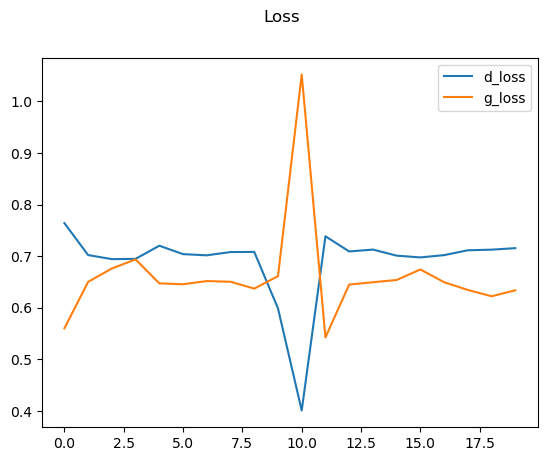

In [78]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

### 5. Test Out the Generator

#### 5.1 Generate Images

In [79]:
imgs = generator.predict(tf.random.normal((16, 8, 1)))
imgs

1/1 [==============================] - 0s 39ms/step


array([[[[8.31429288e-03],
         [2.83956751e-02],
         [2.10709593e-04],
         ...,
         [2.13436052e-01],
         [3.28262538e-01],
         [6.50684908e-02]],

        [[9.53783169e-02],
         [6.74610913e-01],
         [1.32580083e-02],
         ...,
         [2.97886789e-01],
         [2.38295570e-01],
         [2.46660151e-02]],

        [[2.08052807e-02],
         [8.56740102e-02],
         [7.46503705e-04],
         ...,
         [1.39387064e-02],
         [1.30946180e-02],
         [9.47102997e-03]],

        ...,

        [[1.53512377e-02],
         [2.07741372e-03],
         [1.24476920e-03],
         ...,
         [3.54799049e-05],
         [2.71024942e-06],
         [2.93523655e-04]],

        [[2.15260193e-01],
         [1.11793630e-01],
         [2.46796429e-01],
         ...,
         [2.46782351e-04],
         [7.63690623e-05],
         [3.26966145e-03]],

        [[3.10044698e-02],
         [5.87250525e-03],
         [5.60374325e-03],
         ...,
 

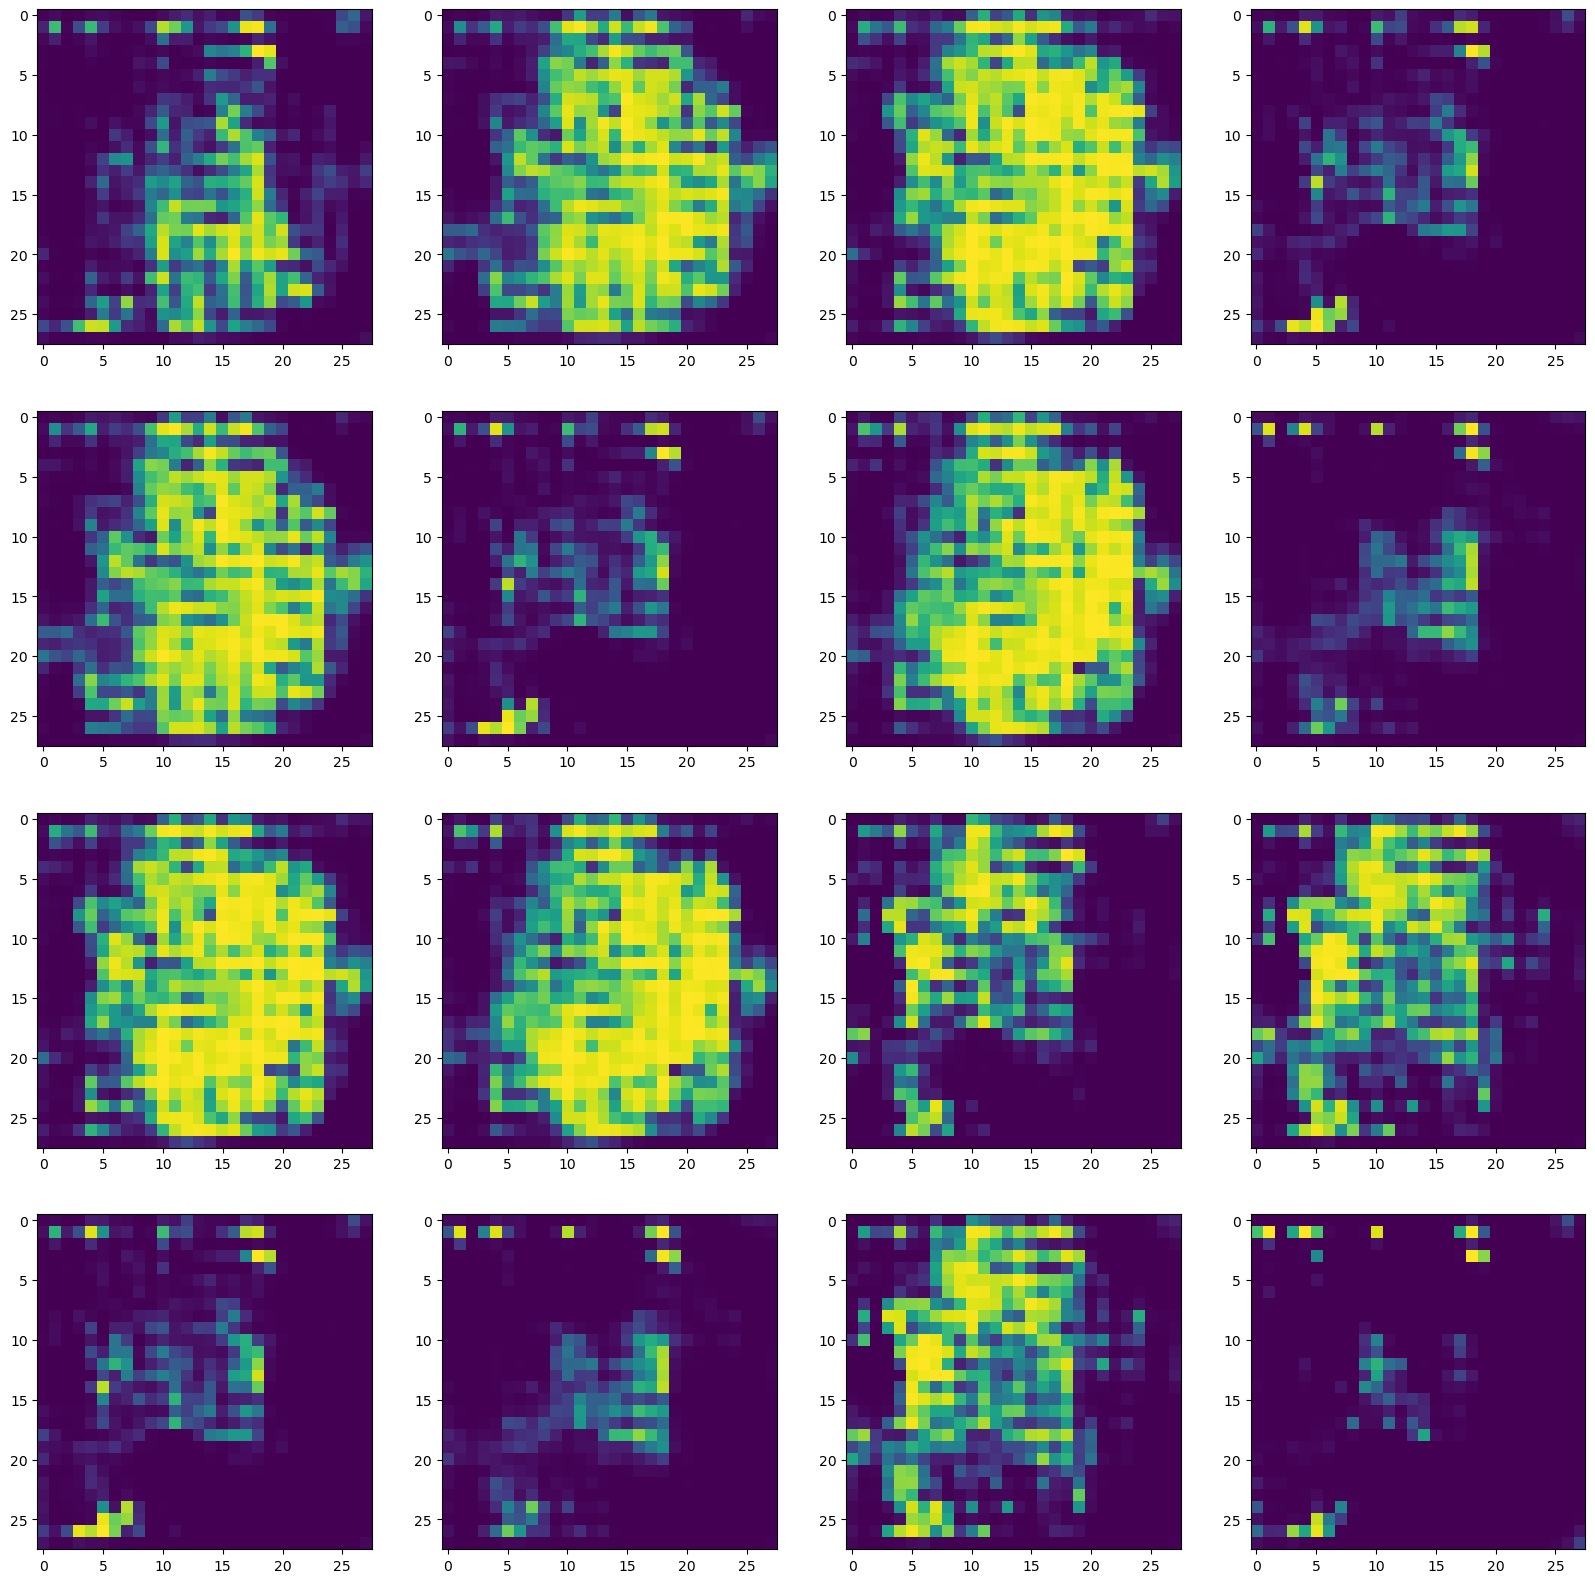

In [81]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

#### 5.2 Save the Model

In [83]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')